In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from visual_behavior import database as db
import visual_behavior.utilities as vbu
import visual_behavior.plotting as vbp
import sys

from scipy import signal

from dro.modules import eye_tracking as et

from multiprocessing import Pool

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib notebook

In [3]:
def fix_path(path):
    if sys.platform == 'linux':
        return path.replace('\\','/')
    else:
        return path
    
def isint(string):
    try:
        int(string)
        return True
    except ValueError:
        return False

In [4]:
def get_experiment_folder(experiment_id):
    folder = fix_path(r"\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\visual_behavior_pilot_analysis\visual_behavior_pilot_manuscript_resubmission")
    for fn in os.listdir(folder):
        if isint(fn[:9]) and int(fn[:9]) == int(experiment_id):
            break
        fn = None
    if fn is not None:
        return os.path.join(folder,fn)

## load manifest

In [5]:
manifest_path = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\visual_behavior_pilot_analysis\visual_behavior_pilot_manuscript_resubmission\visual_behavior_data_manifest.csv'
manifest_path = manifest_path.replace('\\','/')

manifest = pd.read_csv(manifest_path)

In [6]:
def ophys_experiment_id_to_ophys_session_id(oeid):
    return db.convert_id({'ophys_experiment_id':oeid},'ophys_session_id')
manifest['ophys_session_id'] = manifest['experiment_id'].map(lambda oeid:ophys_experiment_id_to_ophys_session_id(oeid))

In [67]:
def load_data(osid, oeid):
    ed = vbu.EyeTrackingData(osid)
    
    eye_movie = vbu.Movie(ed.filepaths['eye_movie'])
    behavior_movie = vbu.Movie(ed.filepaths['behavior_movie'])
    
    folder = get_experiment_folder(oeid)
    timestamp_df = pd.read_hdf(os.path.join(folder,'timestamps.h5'))

    return ed, eye_movie, behavior_movie, timestamp_df

In [68]:
def make_plot(eye_movie, behavior_movie, eye_sync, behavior_sync):
    fig,ax=plt.subplots(2,1, figsize=(15,5), sharex=True)

    ax[0].plot(eye_movie.timestamps_from_file[:-1] - eye_movie.timestamps_from_file[0], np.diff(eye_movie.timestamps_from_file))
    ax[0].plot(behavior_sync[:-1] - behavior_sync[0], np.diff(behavior_sync),alpha=0.5,linewidth=2)
    ax[0].legend(['eye movie timestamp diffs','behavior sync timestamp diffs'])

    ax[1].plot(behavior_movie.timestamps_from_file[:-1] - behavior_movie.timestamps_from_file[0], np.diff(behavior_movie.timestamps_from_file))
    ax[1].plot(eye_sync[:-1] - eye_sync[0], np.diff(eye_sync),alpha=0.5,linewidth=2)
    ax[1].legend(['behavior movie timestamp diffs','eye sync timestamp diffs'])
    fig.tight_layout()
    
    ax[1].set_xlabel('session_time (s)')
    ax[0].set_ylabel('timestamp diff (s)')
    ax[1].set_ylabel('timestamp diff (s)')

    return fig,ax

In [69]:
def analyze_session(oeid):
    osid = ophys_experiment_id_to_ophys_session_id(oeid)
    ed, eye_movie, behavior_movie, timestamp_df = load_data(osid, oeid)

    eye_sync = timestamp_df['eye_tracking'].iloc[0]
    behavior_sync = timestamp_df['behavior_monitoring'].iloc[0]

    data_dict = {
        'ophys_session_id':osid,
        'experiment_id':oeid,
        'eye_movie_frames':eye_movie.frame_count,
        'behavior_movie_frames':behavior_movie.frame_count,
        'eye_tracking_sync_count':len(eye_sync),
        'behavior_monitoring_sync_count':len(behavior_sync),
        'eye_v_eye_xcorr_peak':signal.correlate(np.diff(eye_movie.timestamps_from_file),np.diff(eye_sync)).max(),
        'eye_v_behavior_xcorr_peak':signal.correlate(np.diff(eye_movie.timestamps_from_file),np.diff(behavior_sync)).max(),
        'behavior_v_eye_xcorr_peak':signal.correlate(np.diff(behavior_movie.timestamps_from_file),np.diff(eye_sync)).max(),
        'behavior_v_behavior_xcorr_peak':signal.correlate(np.diff(behavior_movie.timestamps_from_file),np.diff(behavior_sync)).max(),
    }

    fig,ax = make_plot(eye_movie, behavior_movie, eye_sync, behavior_sync)
    fig.savefig(fix_path(r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\visual_behavior_pilot_sync_plots\experiment_id={}.png'.format(oeid)), dpi=300)

    return data_dict

<IPython.core.display.Javascript object>


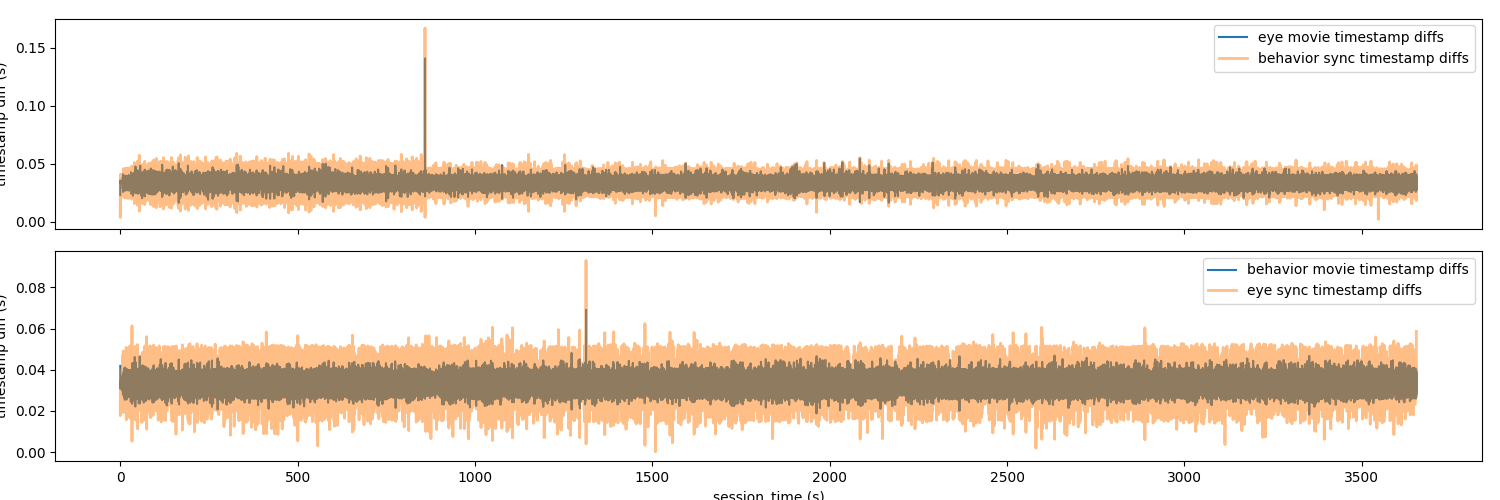

{'ophys_session_id': 673445687,
 'experiment_id': 673460976,
 'eye_movie_frames': 109636,
 'behavior_movie_frames': 109612,
 'eye_tracking_sync_count': 109623,
 'behavior_monitoring_sync_count': 109639,
 'eye_v_eye_xcorr_peak': 121.84203943144927,
 'eye_v_behavior_xcorr_peak': 122.0375607585696,
 'behavior_v_eye_xcorr_peak': 121.96253117265198,
 'behavior_v_behavior_xcorr_peak': 122.03750687907032}

In [70]:
analyze_session(manifest['experiment_id'].unique()[-1])

In [71]:
with Pool(16) as pool:
    ans = pool.map(analyze_session, manifest['experiment_id'].unique())

In [76]:
summary = pd.DataFrame(ans).drop(columns=['behavior_v_behavior_xcorr_peak','behavior_v_eye_xcorr_peak','eye_v_behavior_xcorr_peak','eye_v_eye_xcorr_peak'])

In [85]:
summary['eye_matches_behavior'] = summary['eye_movie_frames'] == summary['behavior_monitoring_sync_count']
summary['eye_matches_eye'] = summary['eye_movie_frames'] == summary['eye_tracking_sync_count']
summary['eye_beh_diff'] = summary['behavior_monitoring_sync_count'] - summary['eye_movie_frames']
summary.to_csv(fix_path(r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\visual_behavior_ophys_pilot_sync_line_summary.csv'),index=False)

In [91]:
fix_path(r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\visual_behavior_ophys_pilot_sync_line_summary.csv')

'//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_ophys_pilot_sync_line_summary.csv'

In [88]:
summary[summary['eye_matches_behavior']==False]['eye_beh_diff'].describe()

count    28.000000
mean      4.928571
std       6.048744
min       1.000000
25%       1.750000
50%       3.500000
75%       5.250000
max      32.000000
Name: eye_beh_diff, dtype: float64

In [82]:
summary['eye_matches_behavior'].mean()

0.7227722772277227

In [89]:
5/60.

0.08333333333333333

In [92]:
summary

,behavior_monitoring_sync_count,behavior_movie_frames,experiment_id,eye_movie_frames,eye_tracking_sync_count,ophys_session_id,eye_matches_behavior,eye_matches_eye,eye_beh_diff
0,110394,110316,644942849,110362,110371,644919226,False,False,32
1,119306,119271,645035903,119293,119303,644953594,False,False,13
2,115876,116136,645086795,115868,116164,645055845,False,False,8
3,109152,109006,645362806,109150,109020,645326094,False,False,2
4,112515,112501,646922970,112511,112521,646846415,False,False,4
5,113529,113515,647108734,113525,113532,647095573,False,False,4
6,112925,112897,647551128,112918,112919,647494834,False,False,7
7,112735,112720,647887770,112731,112738,647794212,False,False,4
8,117011,117308,639253368,117011,117308,639241139,True,False,0
9,113285,113274,639438856,113285,113274,639379154,True,False,0


In [94]:
def get_eyetracking_timestamps(experiment_id):
    folder = get_experiment_folder(experiment_id)
    df = pd.read_hdf(os.path.join(folder,'timestamps.h5'))
    return df['behavior_monitoring'].iloc[0] #note: the 'eye_tracking' and 'behavior_monitoring' labels are swapped in this dataset

In [99]:
oeid = 644942849
osid = 644919226

In [100]:
ed = vbu.EyeTrackingData(int(osid))
sync_timestamps = get_eyetracking_timestamps(ed.ophys_experiment_id)
filename_timestamps = vbu.Movie(ed.filepaths['eye_movie']).timestamps_from_file

In [102]:
len(sync_timestamps),len(filename_timestamps)

(110394, 110362)

<IPython.core.display.Javascript object>


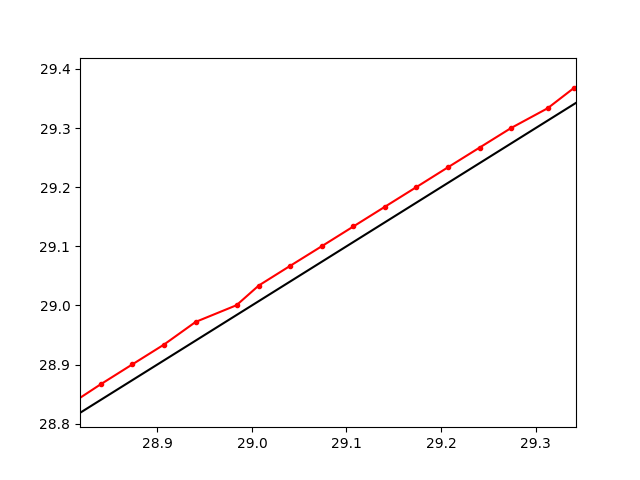

In [103]:
fig,ax=plt.subplots()

ax.plot([0,4000],[0,4000],color='black')
ax.plot(sync_timestamps[:110362]-sync_timestamps[0],filename_timestamps[:110362],'.-r')

<IPython.core.display.Javascript object>


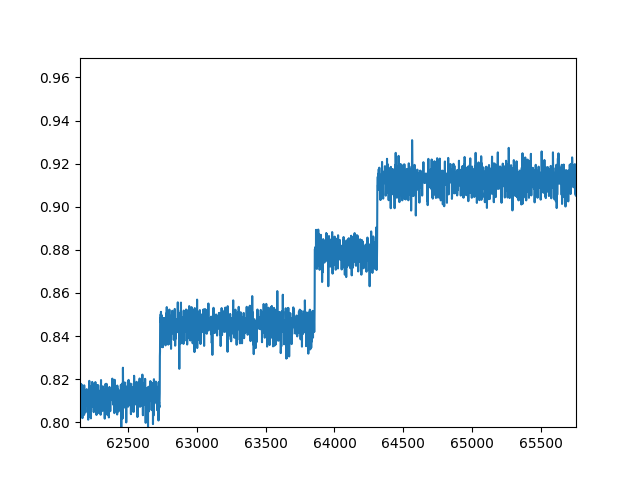

In [105]:
x = sync_timestamps[:110362]-sync_timestamps[0]
y = filename_timestamps[:110362]
fig,ax=plt.subplots()
ax.plot(y-x)